In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.


In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

**오토인코더(autoencoder)**
+ 정의 : 어떤 지도 없이도 잠재 표현(latent representation) 또는 코딩(coding)이라 부르는 입력 데이터의 밀집 표현을 학습할 수 있는 인공 신경망
+ 일부 오토인코더는 훈련 데이터와 매우 비슷한 새로운 데이터를 생성할 수 있음 : 생성 모델(generative model)
+ 단순히 입력을 출력으로 복사하는 방법을 배움
+ 코딩(coding) : 일정 제약 조건하에서 항등 함수(identity function)를 학습하려는 오토인코더의 노력으로 생겨난 부산물

**생성적 적대 신경망(generative adversarial networks, GAN)**
+ **적대적 훈련(adversarial training)** : 생성자와 판별자가 서로 경쟁하는 구조의 신경망을 훈련하는 것
+ **생성자(generator)** : 훈련 데이터와 비슷하게 보이는 데이터를 생성
+ **판별자(discriminator)** : 가짜 데이터와 진짜 데이터를 구별
+ 사용 분야 :  초해상도, 이미지를 컬러로 바꾸기(colorization), 강력한 이미지 편집, 간단한 스케치를 실제 같은 이미지로 바꾸기, 동영상에서 다음 프레임 예측하기, 데이터 증식, 여러 다른 종류의 데이터 생성, 다른 모델의 취약점을 식별하고 개선하기

오토인코더와 GAN 모두 비지도 학습이며, 둘 다 밀집 표현을 학습하고 생성 모델로 사용할 수 있음

## 17.1 효율적인 데이터 표현

+ 훈련하는 동안 오토인코더에 제약을 가해서 데이터에 있는 패턴을 찾아 활용 $\to$ 패턴을 찾으면 효율적으로 정보 저장 가능
+ 오토인코더가 입력을 받아 효율적인 내부 표현으로 바꾸고 입력과 가장 가까운 어떤 것을 출력
+ **인코더(encoder) or 인지 네트워크(recognition network)** : 입력을 내부 표현으로 바꿈
+ **디코더(decoder) or 생성 네트워크(generative network)** : 내부 표현을 출력으로 바꿈

<img src="img/17-1.png" width="500px" align='left'>

+ 출력층의 뉴런 수가 입력 개수와 동일
+ 일반적으로 오토인코더는 다층 퍼셉트론(MLP)과 구조가 동일
+ 오토인코더가 입력을 재구성하기 때문에 출력을 종종 **재구성(reconstruction)**이라 부름
+ 비용 함수는 재구성이 입력과 다를 때 모델에 벌점을 부과하는 **재구성 손실(reconstruction loss)**을 포함
+ **과소완전(undercomplete)** : 내부의 표현이 입력 데이터보다 저차원인 오토인코더
    + 입력 데이터에서 가장 중요한 특성을 학습하도록 만듦

## 17.2 과소완전 선형 오토인코더로 PCA 수행하기

오토인코더가 선형 활성화 함수만 사용하고 비용 함수가 평균 제곱 오차(MSE)라면, 이는 주성분 분석을 수행하는 것으로 볼 수 있음

In [4]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

+ 오토인코더를 인코더와 디코더 두 개 컴포넌트로 구성
+ 오토인코더는 인코더 다음에 디코더가 뒤따르는 Sequential 모델
+ 오토인코더의 출력 개수 = 입력 개수
+ 단순한 PCA를 수행하기 위해서는 활성화 함수 사용 X / 비용 함수는 MSE

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

+ 동일한 데이터셋 X_train이 입력과 타깃에도 사용

In [7]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 1ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 999us/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 993us/step - loss

In [8]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 998us/step


그림 저장 linear_autoencoder_pca_plot


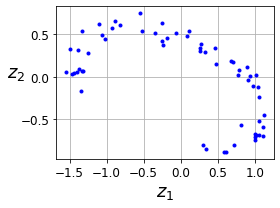

In [9]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

+ 오토인코더는 데이터에 있는 분산이 가능한 많이 보존되도록 데이터를 투영할 최상의 2D 평면을 찾음

<img src="img/17-2.png" width="500px" align='left'>

## 17.3 적층 오토인코더

**적층 오토인코더(stacked autoencoder) or 심층 오토인코더(deep autoencoder)** : 여러 개의 은닉층을 가지는 오토인코더
+ 층을 더 추가하면 더 복잡한 코딩을 학습
+ but, 오토인코더가 너무 강력해지지 않도록 주의
+ 구조 : 전형적으로 가운데 은닉층(코딩 층)을 기준으로 대칭 $\to$ 샌드위치 모양

<img src="img/17-3.png" width="500px" align='left'>

### 17.3.1 케라스를 사용하여 적층 오토인코더 구현하기

패션 MNIST 데이터셋에서 SELU 활성화 함수를 사용해 적층 오토인코더 만들기
+ 오토인코더 모델을 인코더와 디코더 두 개 서브 모델로 나눔
+ 인코더
    + 28 x 28 픽셀의 흑백 이미지를 받음
    + 각 이미지를 784 크기의 벡터로 표현하기 위해 펼침
    + 해당 벡터를 크기가 점점 줄어드는 Dense 층 두 개에 통과시킴(모두 SELU 활성화 함수 사용)
    + 각 입력 이미지에 대해 인코더는 크기가 30인 벡터를 출력
+ 디코더
    + 크기가 30인 코딩을 받음
    + 크기가 점점 커지는 Dense 층 두 개에 통과
    + 최종 벡터를 28 x 28 배열로 변경하여 디코더의 출력이 인코더의 입력과 동일한 크기가 되도록 만듦
+ 적층 오토인코더 compile( ) : 이진 크로스 엔트로프 손실을 사용(재구성 작업을 다중 레이블 이진 분류 문제로 다루는 것)
    + 각 픽셀의 강도는 픽셀이 검정일 확률을 나타냄
+ fit( ) : X_train을 입력과 타깃으로 사용해 모델을 훈련

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

### 17.3.2 재구성 시각화

적절히 훈련되었는지 확인하는 한 가지 방법 : 입력과 출력을 비교(즉, 차이가 너무 크지 않아야 함)

In [ ]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [ ]:
show_reconstructions(stacked_ae)

<img src="img/17-4.png" width="500px" align='left'>

+ 정보를 조금 많이 잃음 $\to$ 대안 : 모델을 더 오래 훈련 or 인코더와 디코더의 층 늘리기 or 코딩의 크기 늘리기
+ but, 네트워크가 너무 강력하면 데이터에서 어떤 유익한 패턴을 학습하지 못하고 완벽한 재구성 미미지를 만들 것

### 17.3.3 패션 MNIST 데이터셋 시각화

적층 오토인코더 모델을 사용해 데이터셋의 차원을 축소 가능
+ 오토인코더의 장점 : 샘플과 특성이 많은 대용량 데이터셋을 다룰 수 있음
    + 적절한 수준으로 차원을 축소한 후 다른 차원 축소 알고리즘을 사용해 시각화하는 것도 전략

패션 MNIST 데이터셋 시각화
+ 적층 오토인코더의 인코더 모델을 사용해 차원을 30으로 줄임
+ t-SNE 알고리즘을 구현한 사이킷런 클래스로 시각화를 위해 차원을 2까지 줄임

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")

t-SNE 알고리즘이 식별한 클러스터가 클래스와 잘 매칭됨

<img src="img/17-5.png" width="500px" align='left'>

### 17.3.4 적층 오토인코더를 사용한 비지도 사전훈련

대부분 레이블되지 않은 대량의 데이터셋이 있을 경우
+ 전체 데이터를 사용해 적층 오토인코더를 훈련
+ 오토인코더의 하위층을 재사용해 실제 문제를 해결하기 위한 신경망을 생성
+ 레이블된 데이터를 사용해 훈련
+ 분류기를 훈련할 때 레이블된 훈련 데이터가 적으면 사전훈련된 층을 동결하는 것이 좋음

모든 훈련 데이터를 사용해 오토인코더를 훈련하고, 그다음에 인코더 층을 재사용하여 새로운 신경망을 만드는 것

<img src="img/17-6.png" width="500px" align='left'>

### 17.3.5 가중치 묶기

오토인코더가 완벽하게 대칭일 땐 디코더의 가중치와 인코더의 가중치를 묶는 것이 일반적인 방법
+ 모델에 있는 가중치의 수를 절반으로 줄여서 훈련 속도를 높이고 과대적합의 위험을 줄여줌

케라스의 사용자 정의 층을 만들어 층 간에 가중치를 묶어줌
+ 일반적인 Dense 층과 비슷
+ but, 다른 Dense 층의 전치된 가중치를 사용
+ but, 편향 벡터는 독자적으로 사용
+ 이전과 비슷하게 새로운 적층 오토인코더를 생성
+ 디코더의 Dense 층은 인코더의 Dense 층과 묶여 있음

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

### 17.3.6 한 번에 오토인코더 한 개씩 훈련하기

**탐욕적 방식의 층별 훈련(greedy layerwise training)**
+ 오토인코더 하나를 훈련하고 이를 쌓아올려서 한 개의 적층 오토인코더를 생성

<img src="img/17-7.png" width="500px" align='left'>

1단계
+ 첫 번째 오토인코더는 입력을 재구성하도록 학습

2단계
+ 이 오토인코더를 사용해 전체 훈련 세트를 인코딩하여 새 훈련 세트를 만듦 $\to$ 이 훈련 세트에서 두 번째 오토인코더를 훈련

3단계
+ 모든 오토인코더를 사용해 전체 네트워크를 만듦

## 17.4 합성곱 오토인코더

**합성곱 오토인코더(convolutional autoencoder)** : 이미지에 대한 오토인코더
+ **인코더** : 합성곱 층과 풀링 층으로 구성된 일반적인 CNN
    + 입력에서 공간 방향의 차원(높이, 너비)을 줄이고 깊이(특성 맵의 개수)를 늘림
+ **디코더** : 전치 합성곱 층을 사용
    + 이미지의 스케일을 늘리고 깊이를 원본 차원으로 되돌림

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

## 17.5 순환 오토인코더

**순환 오토인코더(recurrent autoencoder)** : 시계열이나 텍스트와 같은 시퀀스에 대한 오토인코더
+ **인코더** : 시퀀스-투-벡터 RNN(입력 시퀀스를 하나의 벡터로 압축)
+ **디코더** : 벡터-투-시퀀스 RNN

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

+ 각 이미지를 행의 시퀀스로 간주하여 패션 MNIST 이미지를 처리할 수 있음
+ 타임 스텝마다 입력 벡터를 주입하기 위해 디코더의 첫 번째 층에 RepeatVector 층을 사용

**과소완전 오토인코더(undercomplete autoencoder)** : 흥미로운 특성을 학습하도록 강제하기 위해 코딩 층의 크기를 제한

**과대완전 오토인코더(overcomplete autoencoder)** : 입력 크기만큼 또는 입력보다 큰 코딩 층을 둠

## 17.6 잡음 제거 오토인코더

오토인코더가 유용한 특성을 학습하도록 강제하는 다른 방법 : 입력에 잡음을 추가하고, 잡음이 없는 원본 입력을 복원하도록 훈련하는 것

**적층 잡음 제거 오토인코더(stacked denoising autoencoder)**
+ 잡음 : 입력에 추가된 순수한 가우시안(Gaussian) 잡음 or 드롭아웃처럼 무작위로 입력을 꺼서 발생시킬 수 있음
+ 구현 : 인코더의 입력에 적용한 Dropout 층이 있는(또는 GaussianNoise 층) 일반적인 적층 오토인코더
    + Dropout 층은 훈련하는 동안에만 활성화됨(GaussianNoise 층도 마찬가지)

<img src="img/17-8.png" width="500px" align='left'>

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

잡음 섞인 이미지와 드롭아웃 기반의 잡음 제거 오토인코더로 재구성한 이미지

$\to$ 잡음 제거 오토인코더를 간단하고 효율적으로 이미지에서 잡음을 제거하는 데 사용 가능

<img src="img/17-9.png" width="500px" align='left'>

## 17.7 희소 오토인코더

**희소(sparsity)** : 좋은 특성을 추출하도록 만드는 다른 제약의 방식
+ 비용 함수에 적절한 항을 추가하여 오토인코더가 코딩 층에서 활성화되는 뉴런 수를 감소시키도록 만듦

코딩 층에 시그모이드 활성화 함수를 사용, 큰 코딩 층을 사용

코딩 층의 활성화 값에 $l_1$ 규제를 추가

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

**ActivityRegularization 층** : 입력을 그대로 반환하면서 훈련 손실에 입력의 절댓값의 합을 더함
+ 신경망이 0에 가까운 코딩을 만들도록 유도
+ 입력을 올바르게 재구성하지 못하면 벌칙을 받음(0이 아닌 값이 조금은 출력되어야 함)

훈련 반복마다 코딩 층의 실제 희소 정도를 측정하고 측정된 희소 정도가 타깃 희소 정도와 다르면 모델에 벌칙을 부과

각 뉴런에 대한 평균 활성화 정도를 알면 비용 함수에 **희소 손실(sparsity loss)**을 추가

평균 제곱 오차보다 훨씬 강한 그레이디언트를 가진 **쿨백-라이블러 발산(Kullback-Leibler divergence)**을 사용
<img src="img/17-10.png" width="500px" align='left'>

코딩 층의 각 뉴런에 대해 손실 함수를 계산했다면, 이 손실들을 모두 합해서 비용 함수의 결과에 더함

KL 발산 규제를 적용하기 위해 사용자 정의 규제를 생성

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

코딩 층의 활성화에 KLDivergenceRegularizer를 적용해 희소 오토인코더를 만듦

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

패션 MNIST에 희소 오토인코더를 훈련한 후 코딩 층에 있는 뉴런의 활성화가 거의 0에 가까움

전체 뉴런의 평균 활성화가 0.1 근처

<img src="img/17-11.png" width="500px" align='left'>

## 17.8 변이형 오토인코더

**변이형 오토인코더(variational autoencoder)**
+ 확률적 오토인코더(probabilistic autoencoder) : 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정
+ 생성 오토인코더(generative autoencoder) : 마치 훈련 세트에서 샘플링된 것 같은 새로운 샘플을 생성 가능

효율적인 근사 베이즈 추론 방법인 변분 베이즈 추론(variational Bayesian inference)을 수행

**작동 원리**
+ 인코더는 평균 코딩(mean coding)과 표준편차를 만듦 $\to$ 코딩이 랜덤하게 선택
+ 디코더가 샘플링된 코딩을 보통처럼 디코딩 $\to$ 훈련 샘플을 닮은 최종 출력을 만듦

<img src="img/17-12.png" width="500px" align='left'>

훈련하는 동안 비용 함수가 코딩을 가우시안 샘플들의 군집처럼 보이도록 코딩 공간(coding space) 또는 잠재 공간(latent space) 안으로 점진적으로 이동

비용 함수
+ 오토인코더가 입력을 재생산하도록 만드는 일반적인 재구성 손실
+ 단순한 가우시안 분포에서 샘플된 것 같은 코딩을 가지도록 오토인코더를 강제하는 잠재 손실(latent loss)

### 17.8.1 패션 MNIST 이미지 생성하기

변이형 오토인코더를 사용해 패션 의류처럼 보이는 이미지를 생성

In [ ]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

<img src="img/17-13.png" width="500px" align='left'>

**시맨틱 보간(semantic interpolation)** : 픽셀 수준의 보간 대신 코딩 수준에서 두 이미지를 보간


**순서**
+ 두 이미지를 인코더에 통과시켜 얻은 두 코딩을 보간
+ 보간된 코딩을 디코딩하여 최종 이미지를 얻음
+ 12개의 코딩을 생성하여 3x4 격자로 만듦
+ tf.image.resize( ) 함수를 사용해 이 격자를 5x7 크기로 바꿈
    + resize( ) 함수 : 이중 선형 보간(bilinear interpolation)을 수행
+ 늘어난 모든 행과 열이 보간된 코딩을 가짐
+ 디코더로 이미지를 생성

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

<img src="img/17-14.png" width="500px" align='left'>

## 17.9 생성적 적대 신경망

신경망을 서로 겨루게 하고 경쟁을 통해 신경망을 향상하는 것을 기대

**생성자** : 랜덤한 분포(일반적으로 가우시안 분포)를 입력으로 받고 이미지와 같은 데이터를 출력
+ 판별자를 통해 전달되는 그레이디언트를 입력으로 받음
+ 목표 : 판별자를 속일 만큼 진짜 같은 이미지 생성

**판별자** : 입력된 이미지가 가짜인지 진짜인지 구분
+ 목표 : 진짜 이미지와 가짜 이미지를 구분

<img src="img/17-15.png" width="500px" align='left'>

**훈련 단계**
+ 1단계
    + 판별자를 훈련
    + 가짜 이미지의 레이블을 0으로 세팅, 진짜 이미지는 1로 세팅
    + 판별자는 이진 크로스 엔트로피를 사용해 한 스텝 동안 이렇게 레이블된 배치로 훈련
+ 2단계
    + 생성자를 훈련
    + 생성자를 사용해 다른 가짜 이미지 배치를 생성 $\to$ 판별자를 사용해 이미지가 진짜인지 가짜인지 판별
    + 레이블을 모두 1로 세팅(생성자가 판별자가 진짜라고 잘못 믿을 이미지를 생성) $\to$ 판별자의 가중치 동결

**패션 MNIST 데이터셋으로 간단한 GAN 만들기**
+ 생성자(오토인코더의 디코더와 유사)와 판별자(일반적인 이진 분류기) 생성
+ 각 훈련 반복의 두 번째 단계에서 생성자와 판별자가 연결된 전체 GAN 모델이 필요

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

**생성자** : gan 모델을 통해서만 훈련 $\to$ 따로 compile할 필요 X

**판별자** : 이진 분류기 $\to$ 이진 크로스 엔트로피 손실을 사용

**gan 모델** : 이진 분류기 $\to$ 이진 크로스 엔트로피 손실을 사용
+ 두 번째 단계에서 판별자를 훈련하면 X $\to$ gan 모델을 compile하기 전에 판별자가 훈련되지 않도록 설정
+ trainable 속성 : 모델을 컴파일할 때만 영향
    + discriminator의 fit( ) 메서드, train_on_batch( ) 메서드를 호출해도 판별자는 여전히 훈련됨
    + gan 모델의 메서드를 호출할 때는 훈련되지 X

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

훈련이 일반적인 반복이 아님 $\to$ fit( ) 메서드 사용 불가

대신에 사용자 정의 훈련 반복문 생성 $\to$ 먼저, 이미지를 순회하는 Dataset 생성

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)            

1단계
+ 가우시안 잡음을 생성자에 주입하여 가짜 이미지를 생성
+ 판별자를 훈련(trainable 속성을 True로 지정

2단계
+ GAN에 가우시안 잡음을 주입
+ 생성자가 먼저 가짜 이미지를 생성하고 판별자가 이 이미지가 가짜인지 진짜인지 추측
+ 경고를 피하기 위해 trainable 속성을 False로 지정

<img src="img/17-16.png" width="500px" align='left'>

### 17.9.1 GAN 훈련의 어려움

생성자와 판별자는 끊임없이 서로 앞서려고 노력함

**내시 균형(Nash equilibrium)** : 다른 플레이어가 전략을 수정하지 않을 것이므로 어떤 플레이어도 자신의 전략을 수정하지 않는 상태

**모드 붕괴(mode collapse)** : 생성자의 출력의 다양성이 줄어들 때
+ 생성자가 다른 클래스보다 신발을 더 그럴싸하게 만든다고 가정 $\to$ 판별자를 조금 더 속이기 쉽기 때문에 신발 이미지를 더 많이 만들도록 유도
+ 생성자는 점진적으로 다른 이미지를 생성하는 방법을 잊게 됨
+ 판별자도 다른 클래스의 가짜 이미지를 구별하는 방법을 잊어버림
+ 판별자가 진짜 신발 중에서 가짜를 구별하게 되면 생성자는 다른 클래스로 옮겨가야 함 $\to$ 판별자도 뒤따라 감

GAN은 몇 개의 클래스 사이를 오가다가 어떤 클래스에서도 좋은 결과를 만들지 못할 수 있음

생성자와 판별자가 지속적으로 서로 영향을 주기 때문에 파라미터 변동이 크고 불안정해질 수 있음

**경험 재생(experience replay)**
+ 매 반복에서 생성자가 만든 이미지를 재생 버퍼에 저장하고 실제 이미지와 이 버퍼에서 뽑은 가짜 이미지를 더해서 판별자를 훈련

**미니배치 판별(mini-batch discrimination)**
+ 배치 간에 얼마나 비슷한 이미지가 있는지 측정하여 이 통계를 판별자에게 제공
+ 판별자는 다양성이 부족한 가짜 이미지 배치 전체를 쉽게 거부할 수 있음

### 17.9.2 심층 합성곱 GAN

**심층 합성곱 GAN(deep convolution GAN, DCGAN)**
+ 판별자의 풀링 층 : 스트라이드 합성곱
+ 생성자의 풀링 층 : 전치 합성곱
+ 생성자와 판별자에 배치 정규화를 사용. 생성자의 출력층과 판별자의 입력층은 제외
+ 완전 연결 은닉층을 제거
+ tanh 함수를 사용해야 하는 출력층을 제외하고 생성자의 모든 층은 ReLU 활성화 함수를 사용
+ 판별자의 모든 층은 LeakyReLU 활성화 함수를 사용

$\to$ 매우 큰 이미지를 생성하면 국부적으로는 특징이 구분되지만 전반적으로는 일관성 없는 이미지를 얻을 가능성이 높음

패션 MNIST에서 잘 작동하는 작은 DCGAN 모델

**생성자**
+ 생성자는 크기 100의 코딩을 받아 6272(7x7x128) 차원으로 투영하고 결과를 7x7x128 크기의 텐서로 바꿈
+ 텐서는 배치 정규화를 거쳐 스트라이드가 2인 전치 합성곱 층에 주입
+ 7x7에서 14x14로 업샘플링되고 깊이는 128에서 64로 감소
+ 결과는 다시 배치 정규화 층을 지나서 스트라이드가 2인 다른 전치 합성곱 층에 주입
+ 14x14에서 28x28로 업샘플링되고 깊이는 64에서 1로 감소
+ tanh 활성화 함수를 사용하므로 출력 범위가 -1에서 1 사이 $\to$ GAN을 훈련하기 전에 훈련 세트를 동일한 범위로 스케일 조정해야 함

**판별자**
+ 이진 분류를 위한 일반적인 CNN과 매우 유사
+ 이미지를 다운샘플링하기 위해 최대 풀링 층 대신에 스트라이드 합성곱(strides=2)을 사용
+ LeakyReLU 활성화 함수를 사용

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

크기를 바꾸고 채널 차원을 추가

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

데이터셋을 만들고 모델을 compile, 훈련

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

<img src="img/17-17.png" width="500px" align='left'>

왼쪽 아래 3개의 이미지 : 그 위에 있는 3개의 이미지의 평균(픽셀 수준의 평균 X, 잠재 공간에서 계산된 평균 $\to$ 자연스러운 얼굴처럼 보임)

이미지 주위를 둘러싼 8개의 이미지 : DCGAN의 시맨틱 보간 능력을 보여주기 위해 동일한 벡터에 약간의 잡음을 추가해 생성한 것

<img src="img/17-18.png" width="500px" align='left'>

**조건 GAN(conditional GAN, CGAN)**
+ 생성자와 판별자에 이미지의 클래스를 추가적인 입력으로 넣는다면 클래스마다 어떻게 보이는지를 학습 $\to$ 생성자가 만드는 이미지의 클래스를 조절 가능

### 17.9.3 ProGAN

훈련 초기에 작은 이미지를 생성하고 점진적으로 생성자와 판별자에 합성곱 층을 추가해 갈수록 큰 이미지를 만드는 방법
+ 적층 오토인코더를 층별로 훈련하는 것과 비슷
+ 이전에 훈련된 층은 그대로 훈련 가능하도록 두고 생성자의 끝과 판별자의 시작 부분에 층을 추가

**구조**
+ 기존 합성곱 층('합성곱 층 1')에 (최근접 이웃 필터링을 사용한) 업샘플링 층을 추가
+ 특성 맵이 새로운 합성곱 층('합성곱 층 2')으로 주입되고 다시 새로운 출력 합성곱 층으로 주입
+ '합성곱 층 1'의 가중치를 잃지 않기 위해 두 개의 새로운 합성곱 층을 점진적으로 페이드-인(fade-in)하고 원래 출력층을 페이드-아웃(fade-out)함
+ 모든 합성곱 층은 "same" 스트라이드 1을 사용하므로 입력의 높이와 너비를 보존
+ 출력층의 커널 크기 : 1 $\to$ 입력을 필요한 컬러 채널 수로 투영

<img src="img/17-19.png" width="500px" align='left'>

**미니배치 표준편차 층**
+ 판별자의 마지막 층 근처에 추가
+ 입력에 있는 모든 위치에 대해 모든 채널과 배치의 모든 샘플에 걸쳐 표준편차를 계산
+ 이 표준편차는 모든 픽셀에 대해 평균하여 하나의 값을 얻음
+ 추가적인 특성 맵이 배치의 모든 샘플에 추가되고 계산된 이 값으로 채워짐
+ 효과
    + 판별자는 이 통계를 쉽게 얻을 수 있고 다양성이 아주 적은 이미지를 만드는 생성자에게 속을 가능성이 줄어듦
    + 생성자가 조금 더 다양한 출력을 만들도록 유도하고 모드 붕괴의 위험을 줄임


**동일한 학습 속도**
+ He 초기화 대신 평균이 0이고 표준편차가 1인 가우시안 분포를 사용해 모든 가중치를 초기화
+ 런타임(runtime)에 He 초기화에 있는 동일한 인자로 가중치의 스케일을 낮춤
+ 효과
    + 가중치 초기화에서 스케일을 맞추지 않고 모델의 한 부분으로 가중치를 조정함으로써 훈련 내내 모든 파라미터의 다이내믹 레인지를 동일하게 만듦
    + 모든 가중치가 동일한 속도로 학습됨(훈련 속도와 안정성을 높임)

**픽셀별 정규화 층**
+ 생성자의 합성곱 층 뒤에 추가
+ 동일한 이미지의 동일 위치에 있는 모든 활성화를 채널에 대해 정규화
+ 효과
    + 생성자와 판별자 사이의 과도한 경쟁으로 활성화 값이 폭주되는 것을 막음

### 17.9.4 StyleGAN

**스타일 트랜스퍼(style transfer)**
+ 생성된 이미지가 훈련된 이미지와 같은 다양한 크기의 국부적인 구조를 갖도록 만ㄷ름
+ 생성된 이미지의 품질을 크게 높여줌
+ 판별자와 손실 함수는 그대로 두고 생성자만 변경

**StyleGAN 구조** : 네트워크 두 개로 구성
+ **매핑 네트워크** : 코딩을 여러 스타일 벡터로 변환
    + 8개의 MLP가 잠재 표현 $z$(즉, 코딩)을 벡터 $w$로 매핑
    + 이 벡터는 여러 아핀 변환(affine transformation)으로 전달되어 벡터 여러 개를 생성
+ **합성 네트워크** : 이미지 생성을 책임짐
    + 입력을 합성곱 여러 개와 업샘플링 층에 통과
    + 입력과 모든 합성곱 층의 출력에 잡음이 조금 섞임
    + 잡음이 섞인 다음에 적응적 인스턴스 정규화(adaptive insance normalization, AdaIN) 층이 뒤따름
    
    
<img src="img/17-20.png" width="500px" align='left'>

코딩에 독립적으로 잡음을 추가하는 것이 매우 중요

+ StyleGAN은 추가된 잡음을 사용하여 이미지의 각 부분에 정확한 양의 무작위성을 추가 가능
+ 일정 비율의 이미지를 두 개의 다른 코딩으로 생성하는 **믹싱 규제(mixing regularization) / 스타일 믹싱(style mixing)**이라 불리는 기법을 사용